#DeBERTa for Sentiment Analysis


In [1]:
!pip install transformers datasets scikit-learn --quiet


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import DebertaTokenizer, DebertaForSequenceClassification, Trainer, TrainingArguments
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import time

In [4]:
df.head()

,Text,Score,label
0,I have bought several of the Vitality canned d...,5,1
1,Product arrived labeled as Jumbo Salted Peanut...,1,0
2,This is a confection that has been around a fe...,4,1
3,If you are looking for the secret ingredient i...,2,0
4,Great taffy at a great price. There was a wid...,5,1


In [3]:
# Load dataset
df = pd.read_csv('/content/Reviews.csv', on_bad_lines='warn', engine='python')
df.head()
df = df[['Text', 'Score']].dropna()
df = df[df['Score'] != 3]
df['label'] = df['Score'].apply(lambda x: 1 if x > 3 else 0)

/tmp/ipython-input-3-527899158.py:2: ParserWarning: Skipping line 56000: unexpected end of data

  df = pd.read_csv('/content/Reviews.csv', on_bad_lines='warn', engine='python')


In [5]:
df.shape
df = df.sample(15000)

In [6]:
# Split data
train_texts, val_texts, train_labels, val_labels = train_test_split(df['Text'], df['label'], test_size=0.2, random_state=42)

In [7]:
# Tokenization
tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=128)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

In [8]:
# Dataset class
class AmazonDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()} | {'labels': torch.tensor(self.labels[idx])}
    def __len__(self):
        return len(self.labels)

train_dataset = AmazonDataset(train_encodings, train_labels.tolist())
val_dataset = AmazonDataset(val_encodings, val_labels.tolist())

In [9]:
# Load model
model = DebertaForSequenceClassification.from_pretrained('microsoft/deberta-base', num_labels=2)

pytorch_model.bin:   0%|          | 0.00/559M [00:00<?, ?B/s]

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
from transformers import RobertaForSequenceClassification, Trainer, TrainingArguments
import os, time

os.environ["WANDB_DISABLED"] = "true"  # Disable W&B tracking

model = DebertaForSequenceClassification.from_pretrained('microsoft/deberta-base', num_labels=2)

training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/RoBERTa_Sentiment/results',
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    eval_strategy="epoch",
    logging_dir='/content/drive/MyDrive/RoBERTa_Sentiment/logs',
    logging_steps=10,
    save_strategy="no"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [11]:
start_time = time.time()
trainer.train()
training_time = time.time() - start_time
print(f"Training time: {training_time:.2f} seconds")

Epoch,Training Loss,Validation Loss
1,0.134600,0.131065
2,0.060800,0.155586


Training time: 701.24 seconds


In [12]:
# Evaluation
start_test = time.time()
predictions = trainer.predict(val_dataset)
test_time = time.time() - start_test

y_pred = predictions.predictions.argmax(axis=-1)
y_true = val_labels[:len(y_pred)]

acc = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')

print(f"Accuracy: {acc}")
print(f"Precision: {prec}")
print(f"Recall: {rec}")
print(f"F1 Score: {f1}")
print(f"Training Time: {training_time:.2f} seconds")
print(f"Testing Time: {test_time:.2f} seconds")

Accuracy: 0.9603333333333334
Precision: 0.9741379310344828
Recall: 0.9791256400157542
F1 Score: 0.9766254174032607
Training Time: 701.24 seconds
Testing Time: 24.75 seconds


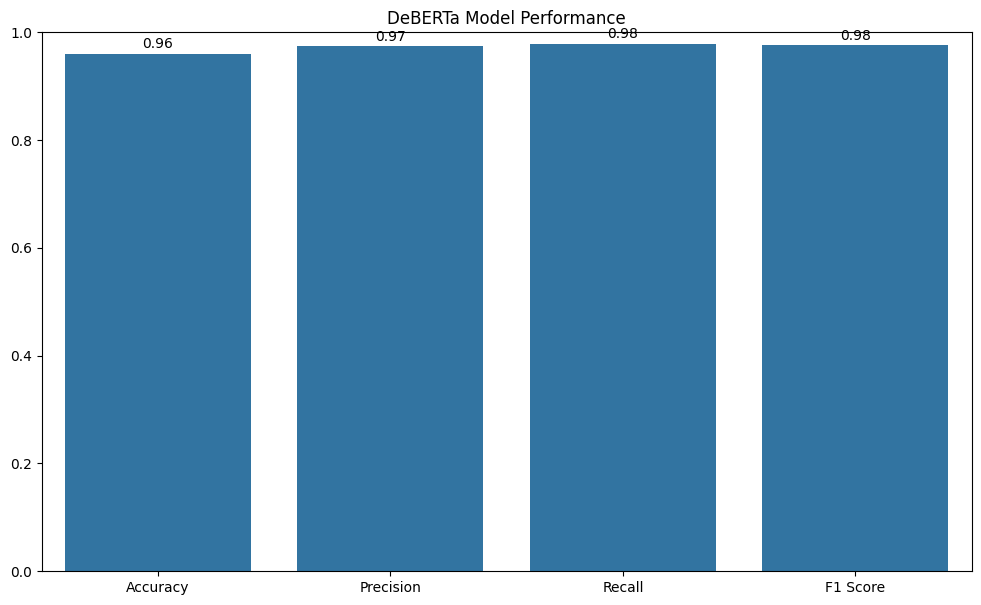

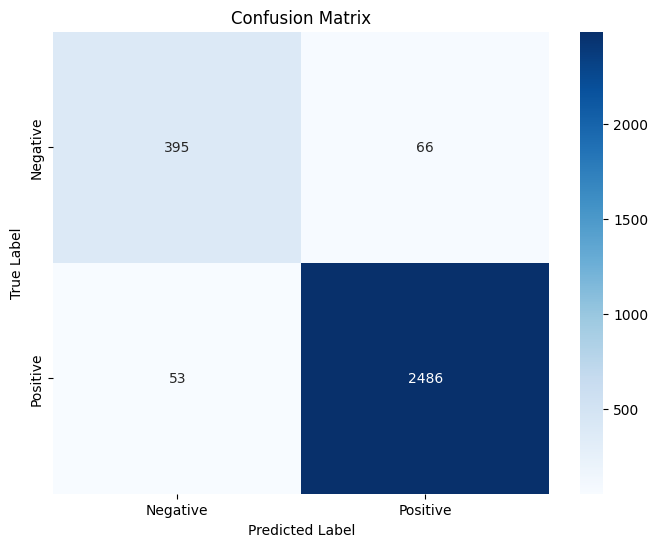

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Performance metrics
metrics = {
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "F1 Score": f1
}

# Create a bar chart
plt.figure(figsize=(12, 7))
sns.barplot(x=list(metrics.keys()), y=list(metrics.values()))
plt.title('DeBERTa Model Performance')
plt.ylim(0, 1)
for index, value in enumerate(list(metrics.values())):
    plt.text(index, value + 0.01, f"{value:.2f}", ha='center')
plt.show()

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()